In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
from deepsvg.svglib.geom import Point
from deepsvg.svglib.svg import SVG
from deepsvg.svglib.svg_path import SVGPath
from deepsvg.svglib.utils import to_gif

from deepsvg.difflib.tensor import SVGTensor
from deepsvg.difflib.utils import *
from deepsvg.difflib.loss import *

In [4]:
import torch.optim as optim
import IPython.display as ipd
from moviepy.editor import ImageClip, concatenate_videoclips, ipython_display

# Differentiable SVGTensor optimization

Load a target SVG and apply the standard pre-processing.

In [5]:
svg = SVG.load_svg("docs/imgs/dolphin.svg").normalize().zoom(0.9).canonicalize().simplify_heuristic()

Convert the SVG to the differentiable SVGTensor data-structure.

In [6]:
svg_target = SVGTensor.from_data(svg.to_tensor())

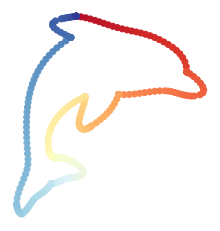

In [7]:
p_target = svg_target.sample_points(10)
plot_points(p_target, show_color=True)


Create an arbitrary SVG whose Bézier parameters will be optimized to match the target shape.

In [23]:
circle = SVG.unit_circle().normalize().zoom(0.9).split(8)  # split: 1/2/4/8
svg_pred = SVGTensor.from_data(circle.to_tensor())

SVGTensor enables to sample points in a differentiable way, so that the loss that will be backpropagated down to the SVG Bézier parameters.

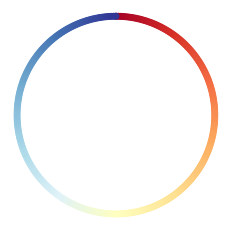

In [24]:
p_pred = svg_pred.sample_points()
plot_points(p_pred, show_color=True)

In [25]:
svg_pred.control1.requires_grad_(True)
svg_pred.control2.requires_grad_(True)
svg_pred.end_pos.requires_grad_(True);

In [26]:
optimizer = optim.Adam([svg_pred.control1, svg_pred.control2, svg_pred.end_pos], lr=0.1)

Write a standard gradient descent algorithm and observe the step-by-step optimization!

In [27]:
# EARTH MOVERS DISTANCE loss

img_list = []

for i in range(150):
    optimizer.zero_grad()

    p_pred = svg_pred.sample_points()
    l = svg_emd_loss(p_pred, p_target)
    l.backward()
    optimizer.step()
    
    if i % 4 == 0:
        img = svg_pred.draw(with_points=True, do_display=False, return_png=True)
        img_list.append(img)
            
to_gif(img_list)

In [50]:
# CHAMFER loss
from scipy.stats import poisson

mean_n_of_points = 100
epochs = 150

n_of_points_per_epoch = poisson.rvs(mean_n_of_points, size=epochs)
print(f"n_of_points_per_epoch: {n_of_points_per_epoch}")

svg_pred = SVGTensor.from_data(circle.to_tensor())
svg_pred.control1.requires_grad_(True)
svg_pred.control2.requires_grad_(True)
svg_pred.end_pos.requires_grad_(True);
optimizer = optim.Adam([svg_pred.control1, svg_pred.control2, svg_pred.end_pos], lr=0.1)


img_list = []

for i in range(epochs):
    optimizer.zero_grad()

    n_points = int(n_of_points_per_epoch[i])
    p_target = svg_target.sample_points(n_points)
    p_pred = svg_pred.sample_points(n_points)
#     l = svg_emd_loss(p_pred, p_target)
    l = chamfer_loss(p_pred, p_target)
    l.backward()
    optimizer.step()

    if i < 5 or i%25 == 0:
        print(f"Loss on iteration {i}: {l:.6f}")
    
    
    if i % 4 == 0:
        img = SVGPath.from_tensor(svg_pred.data).reorder().draw(with_points=True, do_display=False, return_png=True)
        img_list.append(img)

to_gif(img_list)

n_of_points_per_epoch: [ 93  98  87 104 100  93  92  94 101 110  99  98  98 116  92 103 101 116
 109 101 124  92  89 100 103 104  93 100 116 103  81 101  89 112 101 106
  97 102 102  99 117  86 116 104 101  90 108  95 102  92 102 115  84 117
  95 111 103 106  90  94 102 107 104 129 106  99 109 103 111  90 109  94
 105  95  89 106 104 114  96  96  97 105 102  95  98 108 110 103 101 102
 104 102 106 105 106 104  78  88  94  97  95 108  87 104 109  93 102  94
 101 107 104  95  89 104  77  97 102  94  95 100  90 118  86 112  96 121
  96  79 102 103  96  94 103 106  82  97 112 106 104 107 109  96 103 103
 106 111 101  82  96  93]
Loss on iteration 0: 5.776302
Loss on iteration 1: 5.567200
Loss on iteration 2: 5.351564
Loss on iteration 3: 5.137245
Loss on iteration 4: 4.927202
Loss on iteration 25: 2.618798
Loss on iteration 50: 1.215699
Loss on iteration 75: 0.422897
Loss on iteration 100: 0.278255
Loss on iteration 125: 0.215431
